## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 2: Bangkok Housing Data | Part 2: Regression Model

---

[README](../README.md) | [Part 1: Cleaning Datasets](01_Clean.ipynb) | **Part 2: Regression Model** | [Part 3: Interpretation](03_Interpretation.ipynb)

---

### Introduction
- We will build a model using the `housing_clean.csv` dataset, which was prepared during [Part 1: Data Cleaning](#).
- After extensive trial and error, we discovered a few key features that significantly improved the model’s performance—almost by chance. These "lucky" discoveries have been incorporated into the model to enhance its predictive power.

### Import
- We import the essential library, i.e., `pandas`,`numpy`,`seaborn`,`matplotlib.pyplot` that helping us to deal with data.
- The library for making a model mainly comes from `sklearn`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import plotly.express as px

# !pip install missingno
import missingno as msno

from sklearn.linear_model import LinearRegression, HuberRegressor, TheilSenRegressor, RANSACRegressor, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import statsmodels.api as sm

### Load and Check data
- We load data into a new dataframe called, `df`.
- The data has 16072 rows, which is for training 13572 rows, and for prediction 2500 rows.
- There are total of 23 features, excluded `id` and `is_train`.

In [2]:
# Load Data
df = pd.read_csv('../data/housing_clean.csv')

In [3]:
# Check shape
df.shape

(16072, 25)

In [4]:
df.dtypes

id                            int64
province                     object
district                     object
property_type                object
bedrooms                    float64
baths                       float64
floor_area                    int64
log_floor_area              float64
floor_level                 float64
land_area                   float64
log_land_area               float64
nearby_stations               int64
nearest_station_name         object
nearest_station_distance      int64
nearby_supermarkets         float64
has_many_bedrooms             int64
has_many_baths                int64
has_bus_stops                 int64
year_built_bin               object
has_security                  int64
has_pool                      int64
has_sports                    int64
has_parking                   int64
price                       float64
is_train                      int64
dtype: object

In [5]:
# Check number of train and test data
df['is_train'].value_counts()

is_train
1    13572
0     2500
Name: count, dtype: int64

--- 
### Regression Model
- We use OLS from `statsmodels.api`

#### Create dummy variable for `property_type`
- We will set `property_type` Detached House as a baseline.

In [6]:
df['property_type_Condo']  = df['property_type'].map({'Condo': 1, 'Detached House': 0, 'Townhouse':0})
df['property_type_Townhouse']  = df['property_type'].map({'Condo': 0, 'Detached House': 0, 'Townhouse':1})

#### Check correlation among numeric variables
- We check only the training dataset, i.e., `is_train = 1`.
- We observe a strong correlation between `bedrooms` and `baths`, as well as among `has_security`, `has_pool`, `has_sports`, and `has_parking`.
- To reduce the effects of these correlations, we create new interaction columns: `bed_bath`, `has_security_pool`, `has_security_sports`, `has_security_parking`, `has_pool_sports`, `has_pool_parking`, and `has_sports_parking`.

In [7]:
correlation_matrix = df[df['is_train'] == 1].corr(numeric_only = True)

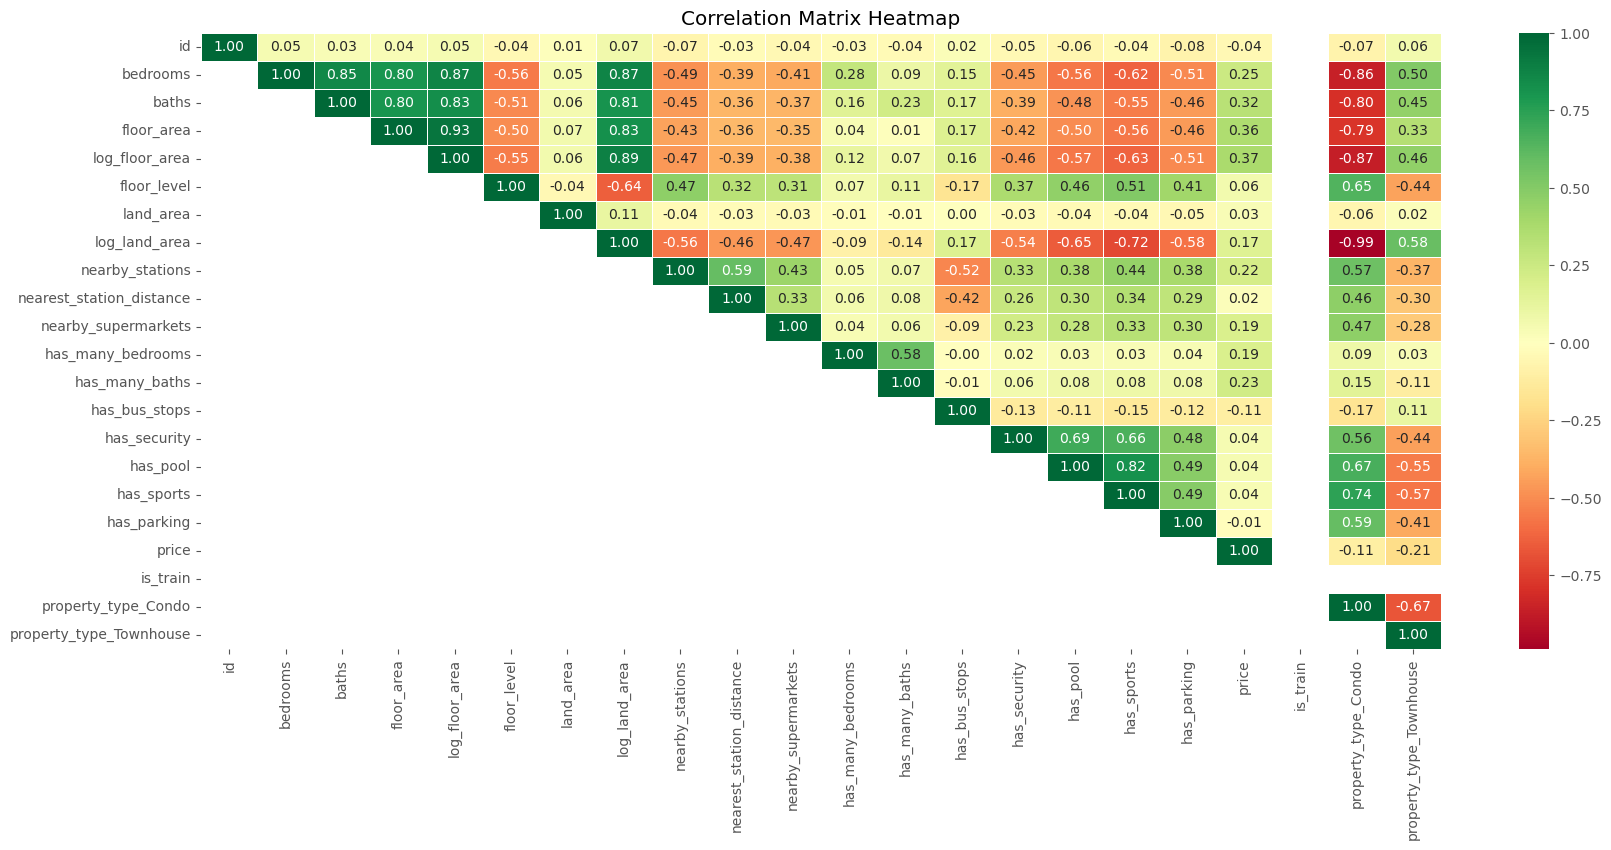

In [8]:
# Show the correlation matrix in form of heatmap

mask_h = np.tril(np.ones_like(correlation_matrix, dtype = bool), k = -1)          # Create a mask for the lower triangle, excluding the diagonal

plt.figure(figsize=(20, 8))                                                       # Set Size
plt.gca().set_facecolor('white')                                                  # Set background to white

# Heatmap with Mask
sns.heatmap(correlation_matrix
            , mask = mask_h
            , annot = True
            , cmap = 'RdYlGn'
            , center = 0
            #, square = True
            , linewidths = 0.5
            , fmt = ".2f"
            #, cbar_kws = {"shrink": .8}
            , linecolor = 'white'
           )

# Display the plot
plt.title("Correlation Matrix Heatmap")
plt.show();

In [9]:
# Create interactions

df['bed_bath'] = df['bedrooms'] * df['baths']
#df['floor_area^2'] = df['floor_area'] ** 2
#df['floor_area^3'] = df['floor_area'] ** 3
df['has_security_pool'] = df['has_security'] * df['has_pool']
df['has_security_sports'] = df['has_security'] * df['has_sports']
df['has_security_parking'] = df['has_security'] * df['has_parking']
df['has_pool_sports'] = df['has_pool'] * df['has_sports']
df['has_pool_parking'] = df['has_pool'] * df['has_parking']
df['has_sports_parking'] = df['has_sports'] * df['has_parking']

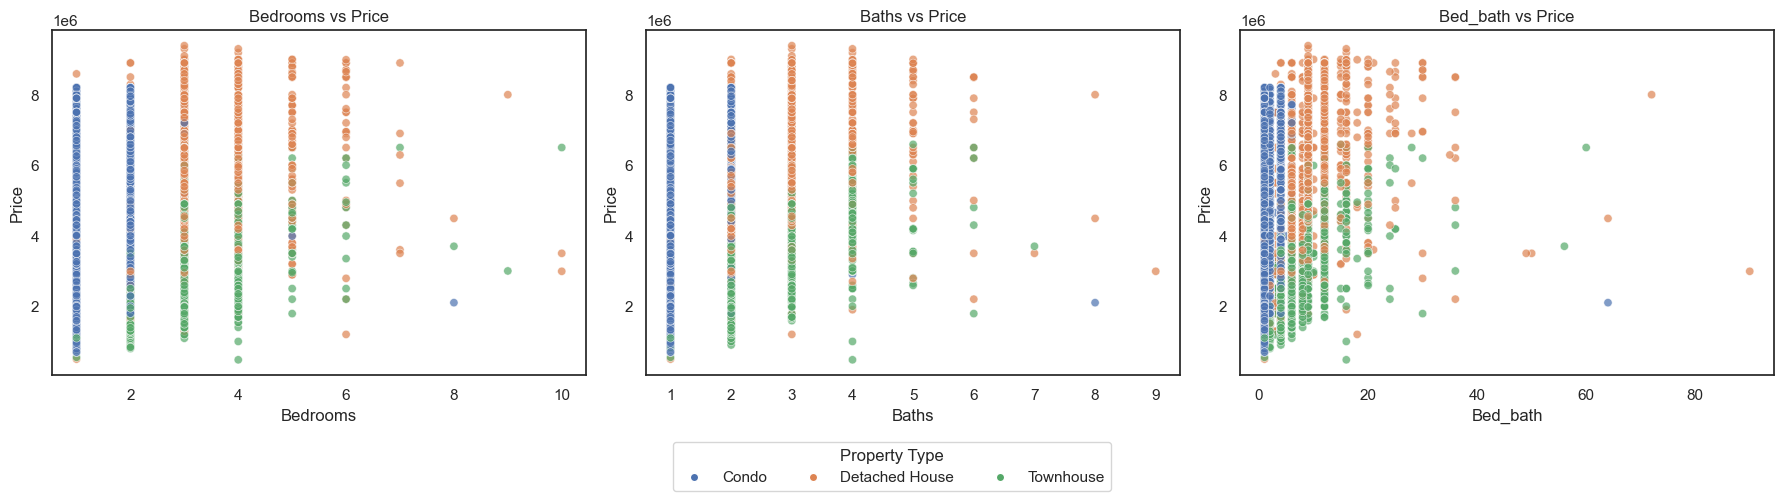

In [10]:
# Relation between bedrooms, bathrooms, and price

df_train = df[df['is_train'] == 1]

sns.set(style = "white")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


features = ['bedrooms', 'baths', 'bed_bath']                 # List of features to plot against 'price'

for ax, feature in zip(axs, features):
    sns.scatterplot(data = df_train, x = feature, y = 'price', hue='property_type', alpha = 0.7, ax = ax, legend = False)
    ax.set_title(f'{feature.capitalize()} vs Price')
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Price')

# Legend
legend_labels = df['property_type'].unique()
colors = sns.color_palette("deep", len(legend_labels))
handles = [plt.Line2D([0], [0]
                      , marker = 'o'
                      , color = 'w'
                      , label = label
                      , markerfacecolor=colors[i]) for i, label in enumerate(legend_labels)
          ]

# Create a single legend at the bottom of the subplots
fig.legend(handles, legend_labels, title = 'Property Type', loc='center', bbox_to_anchor = (0.5, -0.05), ncol = len(legend_labels))

plt.tight_layout(rect = [0, 0, 1, 0.9])

plt.show();


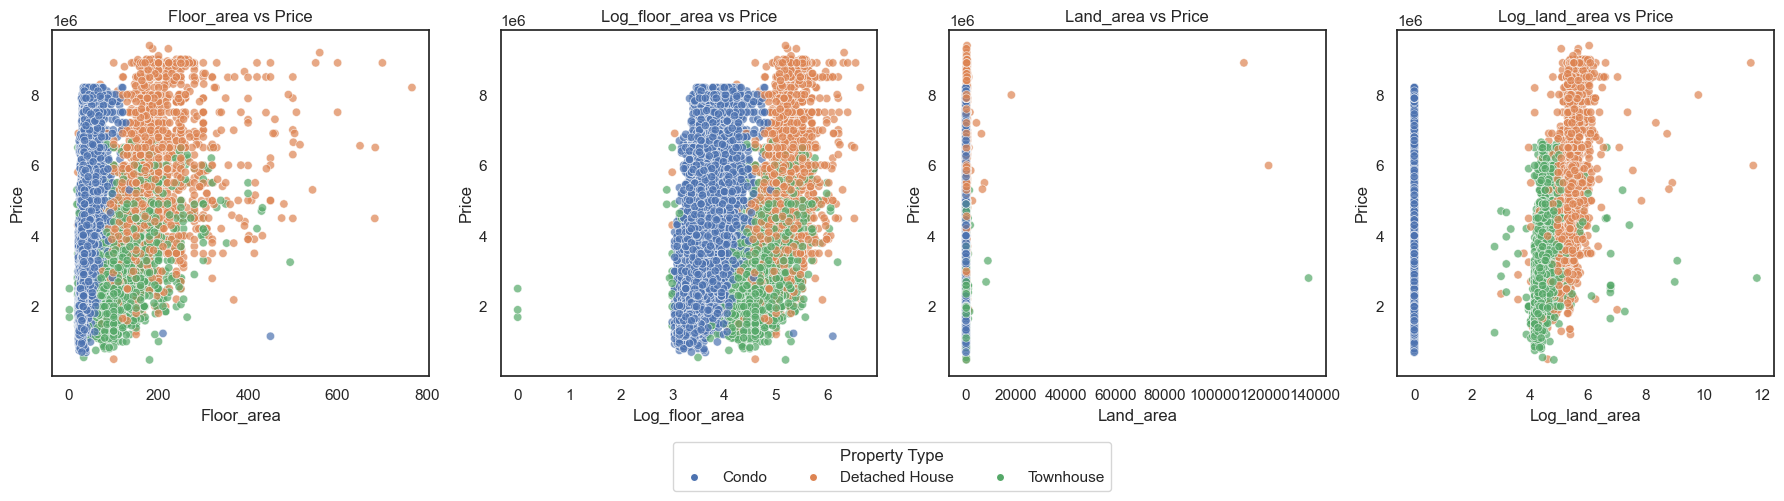

In [11]:
# Relation floor area, and price

sns.set(style = "white")
fig, axs = plt.subplots(1, 4, figsize=(18, 5))


features = ['floor_area', 'log_floor_area', 'land_area', 'log_land_area']                 # List of features to plot against 'price'

for ax, feature in zip(axs, features):
    sns.scatterplot(data = df, x = feature, y = 'price', hue = 'property_type', alpha = 0.7, ax = ax, legend = False)
    ax.set_title(f'{feature.capitalize()} vs Price')
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Price')

# Legend
legend_labels = df['property_type'].unique()
colors = sns.color_palette("deep", len(legend_labels))
handles = [plt.Line2D([0], [0]
                      , marker = 'o'
                      , color = 'w'
                      , label = label
                      , markerfacecolor=colors[i]) for i, label in enumerate(legend_labels)
          ]

# Create a single legend at the bottom of the subplots
fig.legend(handles, legend_labels, title = 'Property Type', loc='center', bbox_to_anchor = (0.5, -0.05), ncol = len(legend_labels))

plt.tight_layout(rect = [0, 0, 1, 0.9])

plt.show();

#### Create dummy for other categorical variables.
- Some features are categorical, such as `province`, `district`, `property_type`, `nearest_station_name`, and `year_built_bin`.
- We processed these features into dummy variables and created a new DataFrame called `dummmies_df`.

In [12]:
# Make all categorical columns into dummies via pd.get_dummies

dummies = ['province', 'district', 'year_built_bin', 'nearest_station_name']     # List of categorical columns for making dummies

# Set some value to be baseline when using pd.get_dummies

df['province'] = np.where(df['province'] == 'Bangkok', np.nan, df['province'])                    # Set Bankok to NaN
df['district'] = np.where(df['district'] == 'Phra Khanong', np.nan, df['district'])               # Set Phra Khanong to NaN
df['year_built_bin'] = np.where(df['year_built_bin'] == 'unknown', np.nan, df['year_built_bin'])  # Set unknown to NaN

In [13]:
df.head(1)

,id,province,district,property_type,bedrooms,baths,floor_area,log_floor_area,floor_level,land_area,...,is_train,property_type_Condo,property_type_Townhouse,bed_bath,has_security_pool,has_security_sports,has_security_parking,has_pool_sports,has_pool_parking,has_sports_parking
0,10936325,NaN,Watthana,Condo,1.0,1.0,49,3.89182,8.0,0.0,...,1,1,0,1.0,1,1,0,1,0,0


In [14]:
# Get Dummies

df_dummies = pd.get_dummies(df
                            , columns = dummies
                            , drop_first = False
                           )

#### Set features X and target y from `dummies_df`
- For training dataset, we filter `dummies_df` with `is_train = 1`
- We drop `is_train`, `id`, and `price` for features `X`. We also drop `floor_area` and `land_area`, and using `log_floor_area` and `log_land_area` instead.
- The target variable is `price` and set it to `y`

In [15]:
# X is training's data with getting dummies, y is corresponding to X

# For X, remove columns is_train, id, property_type, and price
X = df_dummies[df_dummies['is_train'] == 1].drop(columns=['is_train','id','property_type','price','floor_area','land_area'])

# Set all columns as float for using in model
X = X.astype(float)

# For y, only dependent variable, price
y = df_dummies[df_dummies['is_train'] == 1]['price']

# Check shape
X.shape, y.shape

((13572, 223), (13572,))

In [16]:
X.head()

,bedrooms,baths,log_floor_area,floor_level,log_land_area,nearby_stations,nearest_station_distance,nearby_supermarkets,has_many_bedrooms,has_many_baths,...,nearest_station_name_S10 Talat Phlu BTS,nearest_station_name_S11 Wutthakat BTS,nearest_station_name_S2 Sala Daeng BTS,nearest_station_name_S3 Chong Nonsi BTS,nearest_station_name_S4 Saint Louis BTS,nearest_station_name_S5 Surasak BTS,nearest_station_name_S6 Saphan Taksin BTS,nearest_station_name_S8 Wongwian Yai BTS,nearest_station_name_S9 Pho Nimit BTS,nearest_station_name_W1 National Stadium BTS
0,1.0,1.0,3.891820,8.0,0.000000,3.0,720.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,3.526361,4.0,0.000000,2.0,650.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,3.0,5.135798,0.0,5.513429,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,4.787492,0.0,4.276666,1.0,10.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,4.077537,4.0,0.000000,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Process of Model 0  
- Split 80% of X into the training set and use the remaining 20% as the testing set.
- Add a constant for the intercept term to X_train and X_test.
- Fit the model and check the summary.
- The scores for both the training and testing sets are at 0.763 and 0.752, maybe little overfit.
- The root mean square errors both the training and testing sets are 950,692 and 963,278.
- According to the summary, there are non-significant variables — `has_many_baths`,`has_security`, `has_pool`, `has_sports`, `has_security_pool`, `has_security_sports` and `has_pool_sports` — each with a p-value greater than 0.05.
- There are some values predict to be 0, we will take care of it later.

In [17]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Add a constant to the model (for the intercept)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the OLS model

model = sm.OLS(y_train, X_train).fit()

In [18]:
# Check the summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     157.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:10:39   Log-Likelihood:            -1.6485e+05
No. Observations:               10857   AIC:                         3.301e+05
Df Residuals:                   10638   BIC:                         3.317e+05
Df Model:                         218                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                  -8.208e+06   2.81e+05    -29.181      0.000   -8.76e+06   -7.66e+06
bedrooms                                                                4.795e+05   4.58e+04     10.468      0.000     3.9e+05    5.69e+05
baths                                                                   1.134e+06   5.04e+04     22.483      0.000    1.03e+06    1.23e+06
log_floor_area                                                            1.5e+06    3.7e+04     40.508      0.000    1.43e+06    1.57e+06
floor_level                                                             2.939e+04   1584.970     18.544      0.000    2.63e+04    3.25e+04
log_land_area                                                           6.284e+05   3.84e+04     16.375      0.000    5.53e+05    7.04e+05
nearby_stations                                                         1.081e+05   3.36e+04      3.221      0.001    4.23e+04    1.74e+05
nearest_station_distance                                               -1239.6683     64.740    -19.148      0.000   -1366.571   -1112.766
nearby_supermarkets                                                     1.038e+04   3311.950      3.135      0.002    3891.863    1.69e+04
has_many_bedrooms                                                       2.022e+05   4.98e+04      4.059      0.000    1.05e+05       3e+05
has_many_baths                                                         -7.798e+04   5.77e+04     -1.351      0.177   -1.91e+05    3.52e+04
has_bus_stops                                                            1.75e+05   3.36e+04      5.204      0.000    1.09e+05    2.41e+05
has_security                                                           -2.763e+04   5.02e+04     -0.551      0.582   -1.26e+05    7.07e+04
has_pool                                                                1.767e+04   2.11e+05      0.084      0.933   -3.96e+05    4.31e+05
has_sports                                                              3.102e+05   2.49e+05      1.243      0.214   -1.79e+05    7.99e+05
has_parking                                                              -2.3e+05   5.68e+04     -4.050      0.000   -3.41e+05   -1.19e+05
property_type_Condo                                                     2.988e+06   2.14e+05     13.948      0.000    2.57e+06    3.41e+06
property_type_Townhouse                                                -1.055e+06   4.79e+04    -22.039      0.000   -1.15e+06   -9.61e+05
bed_bath                                                               -1.694e+05   1.09e+04    -15.510      0.000   -1.91e+05   -1.48e+05
has_security_pool        

In [19]:
# Predict and check score on training set and testing set

print(f'Score of Training Set: {r2_score(y_train,model.predict(X_train)):,.3f}')
print(f'RMSE of Training Set: {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):,.0f}')

print(f'Score of Testing Set: {r2_score(y_test,model.predict(X_test)):,.3f}')
print(f'RMSE of Testing Set: {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):,.0f}')

Score of Training Set: 0.763
RMSE of Training Set: 950,692
Score of Testing Set: 0.752
RMSE of Testing Set: 963,278


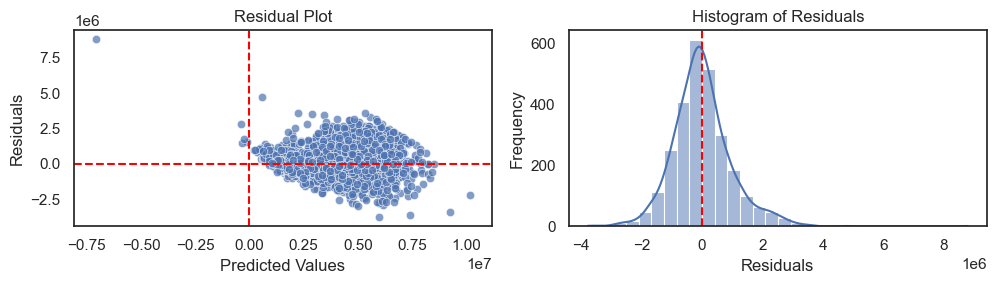

In [20]:
# Calculate residuals

y_preds = model.predict(X_test)
residuals = y_test - y_preds

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Residual Plot
sns.scatterplot(x = y_preds, y = residuals, ax = axs[0], alpha = 0.7)
axs[0].axhline(0, color = 'red', linestyle = '--')
axs[0].axvline(0, color = 'red', linestyle = '--')
axs[0].set_title('Residual Plot')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[0].set_xlim([min(y_preds) - 0.1e7, max(y_preds) + 0.1e7])  # Optional: set x-limits

# Histogram of Residuals
sns.histplot(residuals, bins = 30, kde = True, ax = axs[1])
axs[1].set_title('Histogram of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].axvline(0, color = 'red', linestyle = '--')  # Add a vertical line at 0

# Adjust layout
plt.tight_layout()
plt.show()

#### Fine-tune Model 0 to Model 1
- Drop all non-significant variables from Model 0 and then repeat the process.
- The scores for both the training and testing sets are 0.761 and 0.751. 
- The root mean square errors both the training and testing sets are 955,261 and 965,546.
- According to the summary, there are non-significant variables — `has_sports_parking` with a p-value greater than 0.05.
- There are also have negative predicted values.

In [21]:
# Drop non-significant columns

X1 = X.drop(columns = ['has_many_baths'
                       , 'has_security'
                       , 'has_pool'
                       , 'has_sports'
                       , 'has_security_pool'
                       , 'has_security_sports'
                       , 'has_pool_sports'
                       ]
             , errors = 'ignore'
            )

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, train_size = 0.8, random_state = 42)

X1_train = sm.add_constant(X1_train)
X1_test = sm.add_constant(X1_test)

model1 = sm.OLS(y1_train, X1_train).fit()       

In [22]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     160.2
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:10:40   Log-Likelihood:            -1.6490e+05
No. Observations:               10857   AIC:                         3.302e+05
Df Residuals:                   10645   BIC:                         3.318e+05
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -8.16e+06    2.8e+05    -29.141      0.000   -8.71e+06   -7.61e+06
bedrooms                                                                4.815e+05   4.54e+04     10.603      0.000    3.93e+05    5.71e+05
baths                                                                   1.136e+06   4.39e+04     25.904      0.000    1.05e+06    1.22e+06
log_floor_area                                                          1.498e+06   3.72e+04     40.316      0.000    1.43e+06    1.57e+06
floor_level                                                             2.949e+04   1591.251     18.530      0.000    2.64e+04    3.26e+04
log_land_area                                                           6.373e+05   3.83e+04     16.621      0.000    5.62e+05    7.12e+05
nearby_stations                                                         1.121e+05   3.37e+04      3.327      0.001    4.61e+04    1.78e+05
nearest_station_distance                                               -1229.0951     65.007    -18.907      0.000   -1356.520   -1101.670
nearby_supermarkets                                                     1.029e+04   3324.492      3.095      0.002    3772.450    1.68e+04
has_many_bedrooms                                                       1.713e+05   4.79e+04      3.576      0.000    7.74e+04    2.65e+05
has_bus_stops                                                           1.858e+05   3.37e+04      5.513      0.000     1.2e+05    2.52e+05
has_parking                                                            -3.319e+05   5.33e+04     -6.225      0.000   -4.36e+05   -2.27e+05
property_type_Condo                                                     3.005e+06   2.14e+05     14.012      0.000    2.58e+06    3.43e+06
property_type_Townhouse                                                -1.094e+06   4.76e+04    -22.999      0.000   -1.19e+06      -1e+06
bed_bath                                                               -1.701e+05   1.04e+04    -16.275      0.000   -1.91e+05    -1.5e+05
has_security_parking                                                      1.9e+05   6.14e+04      3.094      0.002    6.96e+04     3.1e+05
has_pool_parking                                                        2.992e+05   5.14e+04      5.816      0.000    1.98e+05       4e+05
has_sports_parking                                                      8.206e+04   5.15e+04      1.594      0.111   -1.88e+04    1.83e+05
province_Nonthaburi                                                    -8.372e+05   9.68e+04     -8.648      0.000   -1.03e+06   -6.47e+05
province_Samut Prakan    

In [23]:
# Predict and check score on training set and testing set

print(f'Score of Training Set: {r2_score(y1_train,model1.predict(X1_train)):,.3f}')
print(f'RMSE of Training Set: {np.sqrt(mean_squared_error(y1_train, model1.predict(X1_train))):,.0f}')

print(f'Score of Testing Set: {r2_score(y1_test,model1.predict(X1_test)):,.3f}')
print(f'RMSE of Testing Set: {np.sqrt(mean_squared_error(y1_test, model1.predict(X1_test))):,.0f}')

Score of Training Set: 0.761
RMSE of Training Set: 955,261
Score of Testing Set: 0.751
RMSE of Testing Set: 965,546


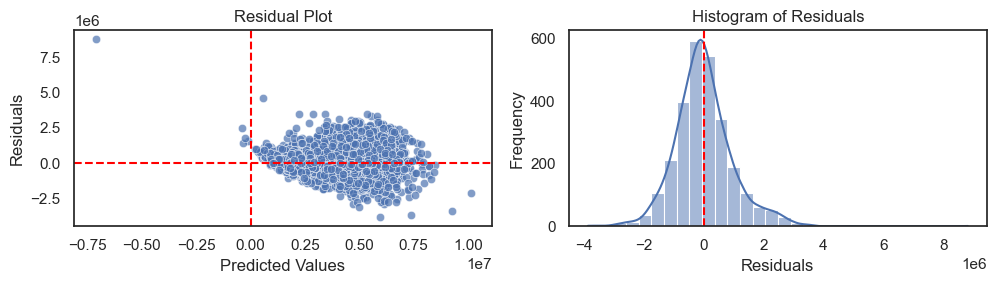

In [24]:
# Calculate residuals

y1_preds = model1.predict(X1_test)
residuals = y1_test - y1_preds

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Residual Plot
sns.scatterplot(x = y_preds, y = residuals, ax = axs[0], alpha = 0.7)
axs[0].axhline(0, color = 'red', linestyle = '--')
axs[0].axvline(0, color = 'red', linestyle = '--')
axs[0].set_title('Residual Plot')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[0].set_xlim([min(y1_preds) - 0.1e7, max(y1_preds) + 0.1e7])  # Optional: set x-limits

# Histogram of Residuals
sns.histplot(residuals, bins = 30, kde = True, ax = axs[1])
axs[1].set_title('Histogram of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].axvline(0, color = 'red', linestyle = '--')  # Add a vertical line at 0

# Adjust layout
plt.tight_layout()
plt.show()

#### Fine-tune Model 1 to Model 2
- Drop `has_sports_parking` from Model 1 and repeat the process
- The scores for both the training and testing sets are 0.760 and 0.751. 
- The root mean square errors both the training and testing sets are 955,375 and 964,986.
- There are also have negative predicted values.

In [25]:
# Drop non-significant columns

X2 = X.drop(columns = ['has_many_baths'
                       , 'has_security'
                       , 'has_pool'
                       , 'has_sports'
                       , 'has_security_pool'
                       , 'has_security_sports'
                       , 'has_pool_sports'
                       , 'has_sports_parking'
                       ]
             , errors = 'ignore'
            )

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, train_size = 0.8, random_state = 42)

X2_train = sm.add_constant(X2_train)
X2_test = sm.add_constant(X2_test)

model2 = sm.OLS(y2_train, X2_train).fit()    

In [26]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     161.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:10:41   Log-Likelihood:            -1.6490e+05
No. Observations:               10857   AIC:                         3.302e+05
Df Residuals:                   10646   BIC:                         3.318e+05
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                  -8.157e+06    2.8e+05    -29.129      0.000   -8.71e+06   -7.61e+06
bedrooms                                                                4.805e+05   4.54e+04     10.580      0.000    3.91e+05    5.69e+05
baths                                                                   1.135e+06   4.39e+04     25.887      0.000    1.05e+06    1.22e+06
log_floor_area                                                          1.497e+06   3.72e+04     40.287      0.000    1.42e+06    1.57e+06
floor_level                                                              2.96e+04   1589.848     18.616      0.000    2.65e+04    3.27e+04
log_land_area                                                           6.374e+05   3.83e+04     16.621      0.000    5.62e+05    7.13e+05
nearby_stations                                                         1.146e+05   3.37e+04      3.407      0.001    4.87e+04    1.81e+05
nearest_station_distance                                               -1232.1804     64.983    -18.962      0.000   -1359.559   -1104.802
nearby_supermarkets                                                     1.034e+04   3324.567      3.111      0.002    3825.281    1.69e+04
has_many_bedrooms                                                       1.722e+05   4.79e+04      3.594      0.000    7.83e+04    2.66e+05
has_bus_stops                                                           1.852e+05   3.37e+04      5.494      0.000    1.19e+05    2.51e+05
has_parking                                                            -3.258e+05   5.32e+04     -6.126      0.000    -4.3e+05   -2.22e+05
property_type_Condo                                                     3.011e+06   2.14e+05     14.041      0.000    2.59e+06    3.43e+06
property_type_Townhouse                                                -1.095e+06   4.76e+04    -23.024      0.000   -1.19e+06      -1e+06
bed_bath                                                               -1.699e+05   1.05e+04    -16.259      0.000    -1.9e+05   -1.49e+05
has_security_parking                                                    2.052e+05   6.07e+04      3.383      0.001    8.63e+04    3.24e+05
has_pool_parking                                                        3.409e+05   4.43e+04      7.694      0.000    2.54e+05    4.28e+05
province_Nonthaburi                                                    -8.359e+05   9.68e+04     -8.634      0.000   -1.03e+06   -6.46e+05
province_Samut Prakan                                                  -7.763e+05   1.01e+05     -7.674      0.000   -9.75e+05   -5.78e+05
district_Bang Bo         

In [27]:
# Predict and check score on training set and testing set

print(f'Score of Training Set: {r2_score(y2_train,model2.predict(X2_train)):,.3f}')
print(f'RMSE of Training Set: {np.sqrt(mean_squared_error(y2_train, model2.predict(X2_train))):,.0f}')

print(f'Score of Testing Set: {r2_score(y2_test,model2.predict(X2_test)):,.3f}')
print(f'RMSE of Testing Set: {np.sqrt(mean_squared_error(y2_test, model2.predict(X2_test))):,.0f}')

Score of Training Set: 0.760
RMSE of Training Set: 955,375
Score of Testing Set: 0.751
RMSE of Testing Set: 964,986


#### Fine-tune Model 2, fix lower bound
- We will adjust y that exceed the lower bound from Model 2 to values that yield the best score.
- After processing, we will set the lower bound to `quantile(0.064)` of training set y.
- The scores for both the training and testing sets after adjusting are 0.767 and 0.763. Get better from overfitting.
- The root mean square errors for both the training and testing sets after adjusting are 941,688 and 941,016.

In [28]:
# Convert predicted y's to Data Series

y2_train_pred_df = pd.Series(model2.predict(X2_train))
y2_train_pred_df.describe().round(2)

count       10857.00
mean      3810634.54
std       1702504.27
min      -5707646.53
25%       2367829.56
50%       3725065.22
75%       5149344.77
max      10353340.09
dtype: float64

In [29]:
# Find p that maximize R^2

y2_train_pred_df = pd.Series(y2_train_pred_df)

ps = np.linspace(0.01, 1, 10_000)
ps_rmse = {}
ps_r2 = {}

for p in ps:
    lb = y2_train_pred_df.quantile(p)
    
    y2_train_pred_adj = np.where(y2_train_pred_df < lb, lb, y2_train_pred_df)  
    
    # Store RMSE and R^2 for the adjusted predictions
    ps_rmse[p] = np.sqrt(mean_squared_error(y2_train, y2_train_pred_adj))
    ps_r2[p] = r2_score(y2_train, y2_train_pred_adj)  

# Get the p that maximizes the R^2 score
optimal_p = max(ps_r2, key=ps_r2.get)

# Get the corresponding RMSE for the optimal p
optimal_rmse = ps_rmse[optimal_p]

In [30]:
print(f'The p that maximizes the score is {optimal_p:.3f}, which gives R^2 score of {ps_r2[optimal_p]:.3f} and RMSE of {optimal_rmse:,.0f}.')

The p that maximizes the score is 0.064, which gives R^2 score of 0.767 and RMSE of 941,688.


In [31]:
# Apply to testing set

y2_test_pred_df = pd.Series(model2.predict(X2_test))
y2_test_pred_df.describe().round(2)

count        2715.00
mean      3782957.06
std       1722064.32
min      -7125819.58
25%       2349431.88
50%       3650628.53
75%       5154661.97
max      10104965.14
dtype: float64

In [32]:
lb = y2_train_pred_df.quantile(optimal_p)
y2_test_pred_adj = np.where(y2_test_pred_df < lb, lb, y2_test_pred_df)

In [33]:
print(f'Score of Testing Set after adjusting: {r2_score(y2_test, y2_test_pred_adj):,.3f}')
print(f'RMSE of Testing Set after adjusting: {np.sqrt(mean_squared_error(y2_test, y2_test_pred_adj)):,.0f}')

Score of Testing Set after adjusting: 0.763
RMSE of Testing Set after adjusting: 941,016


In [34]:
# lb
# Note the lower bound is 1,457,477

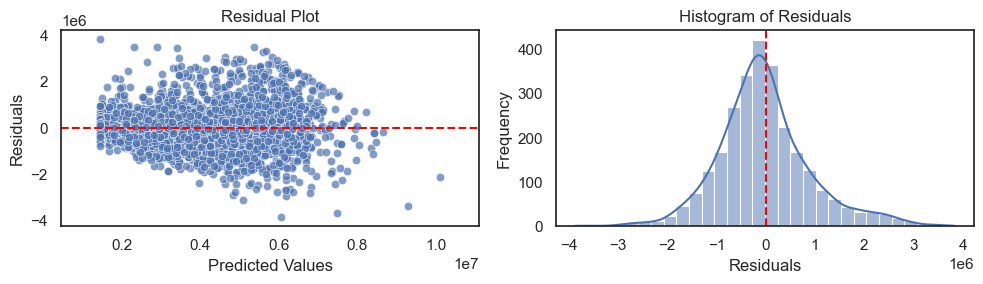

In [35]:
# Calculate residuals

residuals = y2_test - y2_test_pred_adj

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Residual Plot
sns.scatterplot(x = y2_test_pred_adj, y = residuals, ax = axs[0], alpha = 0.7)
axs[0].axhline(0, color = 'red', linestyle = '--')
axs[0].axvline(0, color = 'red', linestyle = '--')
axs[0].set_title('Residual Plot')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[0].set_xlim([min(y2_test_pred_adj) - 0.1e7, max(y2_test_pred_adj) + 0.1e7])  # Optional: set x-limits

# Histogram of Residuals
sns.histplot(residuals, bins = 30, kde = True, ax = axs[1])
axs[1].set_title('Histogram of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].axvline(0, color = 'red', linestyle = '--')  # Add a vertical line at 0

# Adjust layout
plt.tight_layout()

plt.savefig('../images/model_residual_Plot.png', dpi=300, bbox_inches='tight')  # Final model
plt.show()

####  Prediction
- From `df_dummies`, we set `X_submission` which is a dataframe of unknown price.
- Predict using `model1` and adjust the results of `y` with our fine-tune.

In [36]:
# Set X to the submission data

X = df_dummies[df_dummies['is_train'] == 0].drop(columns=['is_train','id','price','property_type','floor_area','land_area'])

# Drop column for apply with model1
X_submission = X.drop(columns = ['has_many_baths'
                       , 'has_security'
                       , 'has_pool'
                       , 'has_sports'
                       , 'has_security_pool'
                       , 'has_security_sports'
                       , 'has_pool_sports'
                       , 'has_sports_parking'
                       ]
             , errors = 'ignore'
            )

X_submission = sm.add_constant(X_submission)

In [37]:
y_submission = model2.predict(X_submission)  

In [38]:
y_submission_df = pd.Series(y_submission)                                 # Convert to Series

y_submission_adj = np.where(y_submission_df < lb, lb, y_submission_df)    # If a value is less than the lower bound, set it to lower bound

In [39]:
submission_df = pd.DataFrame({'id': df_dummies[df_dummies['is_train'] == 0]['id'].reset_index(drop=True)
                              , 'price': y_submission_adj
                             })
submission_df.round(2)

,id,price
0,10317868,4764622.832228
1,10885829,6408290.165061
2,10765951,4035765.927994
3,10003549,6138809.688635
4,10663026,2288562.642327
...,...,...
2495,10889363,5824921.430822
2496,10975839,5344945.451347
2497,10986832,2184010.16195
2498,10687627,1699893.828131


In [40]:
submission_df.to_csv('../data/submission.csv', index = False)

### Export
- We will export the coefficients of the model `model_cofficient.csv` for further interpretation in the next chapter.

In [41]:
summary_df = pd.DataFrame({
    'var': model2.params.index,                  # Variable names
    'coef': model2.params.values,                # Coefficients
    'std_err': model2.bse.values,                # Standard errors
    't': model2.tvalues.values,                  # T-values
    'p_value': model2.pvalues.values,            # P-values
    'lower_ci': model2.conf_int()[0].values,    # Lower confidence interval
    'upper_ci': model2.conf_int()[1].values      # Upper confidence interval
})

summary_stats = {
    'R-squared': model2.rsquared,
    'Adjusted R-squared': model2.rsquared_adj,
    'F-statistic': model2.fvalue,
    'Prob (F-statistic)': model2.f_pvalue,
    'AIC': model2.aic,
    'BIC': model2.bic,
    'Log-Likelihood': model2.llf,
    'No. Observations': model2.nobs,
}

stats_df = pd.DataFrame.from_dict(summary_stats, orient = 'index', columns = ['Value'])

In [46]:
summary_df.head()

,var,coef,std_err,t,p_value,lower_ci,upper_ci
0,const,-8.156851e+06,280025.111708,-29.128998,1.509589e-179,-8.705752e+06,-7.607949e+06
1,bedrooms,4.804597e+05,45412.476595,10.579905,4.972441e-26,3.914428e+05,5.694766e+05
2,baths,1.135365e+06,43857.692130,25.887477,2.368595e-143,1.049396e+06,1.221334e+06
3,log_floor_area,1.497005e+06,37158.484479,40.287027,0.000000e+00,1.424167e+06,1.569842e+06
4,floor_level,2.959678e+04,1589.848000,18.616104,3.821922e-76,2.648038e+04,3.271317e+04


In [43]:
stats_df

,Value
R-squared,0.760498
Adjusted R-squared,0.755774
F-statistic,160.974046
Prob (F-statistic),0.000000
AIC,330231.553732
BIC,331770.285013
Log-Likelihood,-164904.776866
No. Observations,10857.000000


In [45]:
# stats_df.to_csv('../data/model_stats.csv', index = True)
# summary_df.to_csv('../data/model_summary.csv', index = False)